![](http://)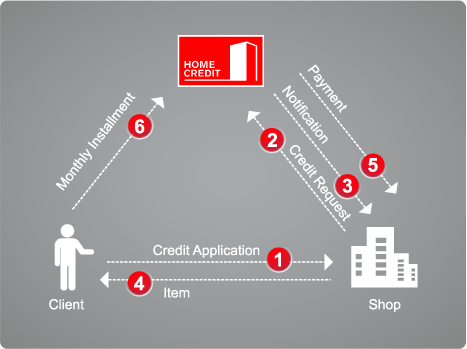
Source:https://programmer.group/

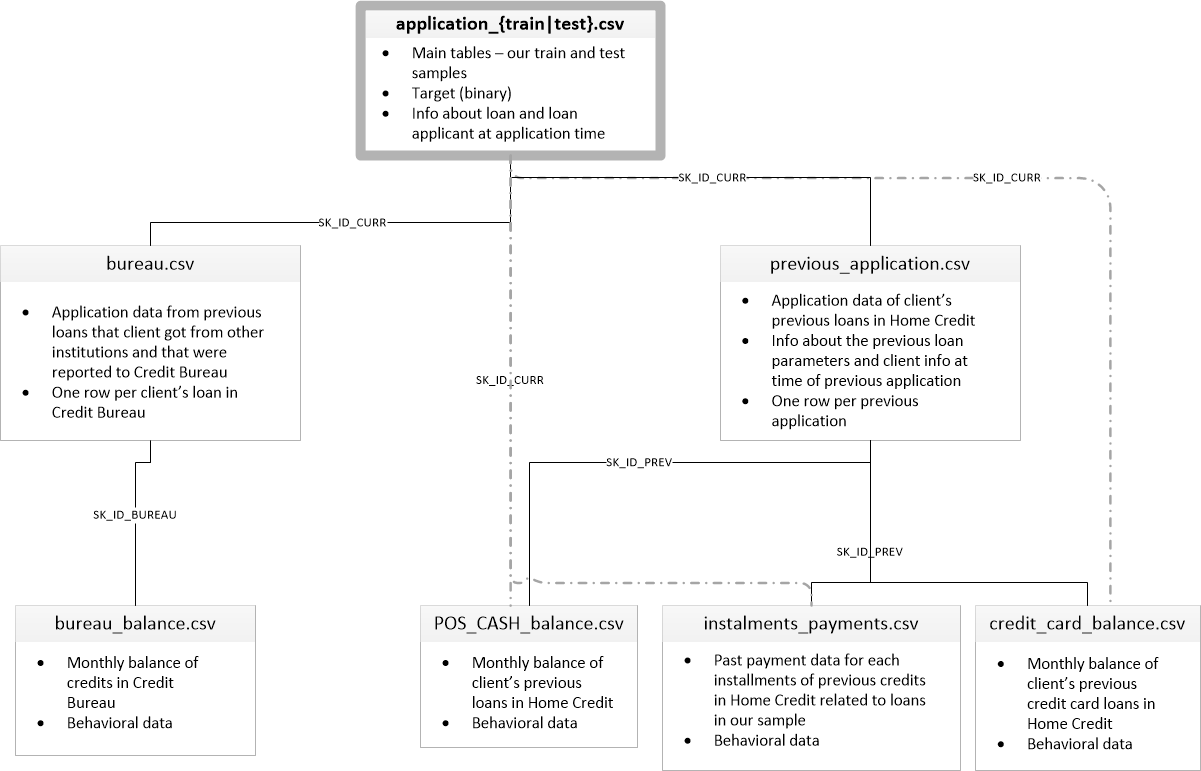

# POS_CASH_balance

In [ ]:
print('\n'.join([''.join([(' Veri_Bilimi_Okulu_VBO_Veri_'[(x-y) % len('Veri_Bilimi_Okulu_VBO_Veri_')] 
                           if ((x*0.05)**2+(y*0.1)**2-1)**3-(x*0.05)**2*(y*0.1)**3 <= 0 else ' ') 
                          for x in range(-30, 30)]) for y in range(15, -15, -1)]))

1. IMPORT SOME NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import time
import matplotlib.pyplot as plt
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


In [ ]:
df_pos= pd.read_csv("../input/home-credit-default-risk/POS_CASH_balance.csv")

2. UNDERSTANDING THE DATA-SET

In [ ]:
df_pos.head()

In [ ]:
df_pos.columns

* SK_ID_PREV 	Home Credit kredisi ile ilişkili önceki kredilerin ID’si
* SK_ID_CURR	Kredinin ID numarası
* MONTHS_BALANCE	Başvuru tarihine göre bakiye ayı (-1 değeri, daha yeni bakiye tarihine karşılık geliyor.)
* CNT_INSTALMENT	Önceki kredinin süresi (zamanla değişebilir)
* CNT_INSTALMENT_FUTURE	Önceki krediden kalan ödenmesi gereken taksitler
* NAME_CONTRACT_STATUS	Ay boyunca sözleşme durumu
* SK_DPD	Önceki kredi ayından itibaren geçen günler
* SK_DPD_DEF	Bir önceki kredinin toleransla (düşük kredi miktarları olan borçlar dikkate alınmaz) vadesi geçen günler

In [ ]:
df_pos.shape

In [ ]:
df_pos.index

In [ ]:
df_pos.isnull().values.any()

3. Checking missing value

In [ ]:
df_pos.isnull().sum()

In [ ]:
def missing_values_table(df_pos):
        mis_val = df_pos.isnull().sum()
        mis_val_percent = 100 * df_pos.isnull().sum() / len(df_pos)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
     
        print ("Your selected dataframe has " + str(df_pos.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(df_pos)

In [ ]:
df_pos.info()

3. ANALYSIS of CATEGORICAL VARIABLE

In [ ]:
# Number of unique classes in each object column
df_pos.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [ ]:
cat_cols = [col for col in df_pos.columns if df_pos[col].dtypes == 'O']
cat_cols

In [ ]:
def cat_summary(data, categorical_cols, target, number_of_classes=10):
    var_count = 0  # How many categorical variables will be reported?
    vars_more_classes = []  # Variables with more than a certain number of classes will be stored.
    for var in categorical_cols:
        if len(df_pos[var].value_counts()) <= number_of_classes:  # Choose by number of classes.
            print(pd.DataFrame({var: data[var].value_counts(),
                                "Ratio": 100 * data[var].value_counts() / len(data),
                                "TARGET_MEDIAN": data.groupby(var)[target].median()}), end="\n\n\n")
            var_count += 1
        else:
            vars_more_classes.append(data[var].name)
    print('%d categorical variables have been described' % var_count, end="\n\n")
    print('There are', len(vars_more_classes), "variables have more than", number_of_classes, "classes", end="\n\n")
    print('Variable names have more than %d classes:' % number_of_classes, end="\n\n")
    print(vars_more_classes)


cat_summary(df_pos, cat_cols, "SK_ID_CURR")

In [ ]:
# NAME_CONTRACT_STATUS: Contract status during the month
df_pos["NAME_CONTRACT_STATUS"].value_counts()

In [ ]:
# Displaying Categorical Variables with Column Graph
sns.countplot(x="NAME_CONTRACT_STATUS", data=df_pos)
plt.show()

5. ANALYSIS of NUMERICAL VARIABLE

In [ ]:
df_pos.describe().T

In [ ]:
df_pos.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

In [ ]:
# How many numeric variables are in the data set?
num_cols = [col for col in df_pos.columns if df_pos[col].dtypes != 'O']
print('Number of numerical variables: ', len(num_cols))

In [ ]:
# What are the names of the numeric variables?
num_cols

In [ ]:
# Visualization of numeric variables
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
hist_for_nums(df_pos, num_cols)

In [ ]:
# Correlation Matrix
corrmat = df_pos.corr()
fig = plt.figure(figsize = (10,7))
sns.heatmap(corrmat,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

6. ONE-HOT ENCODING

In [ ]:
# One hot encoding was applied to NAME_CONTRACT_STATUS categorical variables.
df_pos= pd.get_dummies(df_pos, columns=["NAME_CONTRACT_STATUS"], drop_first=True)